# Treinamento de Redes Neurais Artificiais

**Disciplina:** Redes Neurais Artificiais 2025.1

**Professora orientadora:** 
Elloa B. Guedes (ebgcosta@uea.edu.br)

**Integrantes da equipe:**
* Adriana Raffaella Dos Santos Fonseca (ardsf.eng23@uea.edu.br)
* Ana Flavia De Castro Segadilha Da Silva (afdcsds.eng23@uea.edu.br)
* Davi Aguiar Moreira (dam.eng23@uea.edu.br)
* Guilherme Goncalves Moraes (ggm.eng23@uea.edu.br)
* Ian Garrido Reis (igr.eng23@uea.edu.br)
* Luiz Fernando Borges Brito (lfbb.eng23@uea.edu.br)
* Pedro Vitor Barros Maranhão (pvbm.eng23@uea.edu.br)
* Rita De Cassia Brasil Alves (rdcba.eng23@uea.edu.br)
* Yago De Oliveira Feitoza (ydof.eng21@uea.edu.br)

---

## **Importação das bibliotecas**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer,accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from prettytable import PrettyTable
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

### **Importação e Holdout do dataset**

In [3]:
file_path = 'modified_star_classification.csv'

Dada a expressiva quantidade de exemplos presentes no dataset, optou-se por dividir os dados por holdout 60/40. Além disso, a fim de possibilitar uma análise comparativa de abordagens posteriormente, utiliza-se um seed (42 por convenção).

In [4]:
df = pd.read_csv(file_path)

y = df['class']
X = df.drop('class', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Padroniza as características removendo a média e escalando para variância unitária.
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)


In [5]:
type(X_train)

pandas.core.frame.DataFrame

In [6]:
# Os datasets normalizados estão armazenados dentro da pasta holdout
X_train.to_csv('holdout/x_train.csv', encoding='utf-8')
X_test.to_csv('holdout/x_test.csv', encoding='utf-8')
y_train.to_csv('holdout/y_train.csv', encoding='utf-8')
y_test.to_csv('holdout/y_test.csv', encoding='utf-8')


### **Abordagem 1: 60/40**

Nesta abordagem, utiliza-se o holdout do modo como foi gerado anteriormente, isto é, sem o tratamento do desbalanceamento de dados. 
Checando o Holdout:

In [7]:
class_label_map = ['galaxy', 'star', 'quasar']
training_labels_of_each_class = y_train.value_counts().tolist()
sum_examples = sum(training_labels_of_each_class)
percentage_by_class = {class_label: (class_examples/sum_examples)*100 for class_label, class_examples 
                       in zip(class_label_map, training_labels_of_each_class)}

# Print percentages
for i, (class_name, percentage) in enumerate(percentage_by_class.items(), start=0):
    print(f'Class {i} ({class_name}): {percentage:.2f}%')
    

Class 0 (galaxy): 59.53%
Class 1 (star): 21.64%
Class 2 (quasar): 18.83%


Nesse contexto, o conjunto de treinamento tem a seguinte composição: 59.53% dos são galáxias, 21.64% são estrelas e 18.83% são quasares. Desse modo, utilizam-se métricas ponderadas para permitir uma análise de resultados de acordo com a desigualdade no número de exemplos por classes.

In [8]:
# Uso da pirâmide geométrica

alpha = 3

# Definindo Ni = Número de neurônios na camada de entrada (Número de features em x_train)
Ni = 6 

# Definindo No = Número de neurônios na camada de saída (Número de classes que são previstas em y_train)
No = 3

Nh = round((alpha*((Ni*No)**0.5)), 0)

print(Nh)


13.0


In [9]:
# Construção de Arquiteturas

# Arquiteturas nas quais 13 neurônios foram distribuídos em 2 camadas ocultas

architectures = [
    ((10, 3), 'adam', 'relu', 200, 10),      # 1
    ((3, 10), 'sgd', 'tanh', 200, 10),       # 2
    ((5, 8), 'adam', 'relu', 200, 10),       # 3
    ((8, 5), 'sgd', 'tanh', 200, 10),        # 4
    ((7, 6), 'sgd', 'tanh', 200, 10),        # 5
    ((6, 7), 'adam', 'relu', 200, 10),       # 6
    ((4, 9), 'sgd', 'relu', 200, 10),        # 7
    ((9, 4), 'adam', 'logistic', 200, 10),   # 8
    ((2, 11), 'adam', 'relu', 200, 10),      # 9
    ((11, 2), 'adam', 'logistic', 200, 10),  # 10
]


Além das arquiteturas propostas através da regra da pirâmide, são testadas outras cinco arquiteturas com número de neurônios arbitrários dentro da camada oculta e como elas se desempenhavam.

In [10]:
arbitrary_architectures = [
    ((32, 64), 'adam', 'relu', 200, 10),       # 1
    ((48, 64), 'adam', 'logistic', 200, 10),   # 2
    ((12, 12), 'adam', 'tanh', 200, 10),       # 3
    ((36, 24), 'adam', 'relu', 200, 10),       # 4
    ((28, 28), 'sgd', 'tanh', 200, 10),        # 5
]


In [11]:
# Função de treino das arquiteturas

# Treinamento das arquiteturas propostas com auxílio da regra de pirâmide de acordo com (método 1)

def train_model(X_train, X_test, y_train, y_test, layers, solver, activation, iterations, n_times, lr=1e-3):
    results = []
    print(f'Arquitetura com solver = {solver},' ,
          f' activation = {activation}',
          f'camadas ocultas={layers} ',
          f'Taxa de aprendizado={lr}',
          f'e n° de iterações={iterations} por {n_times}')

    for i in range(1, n_times + 1):
        print(f"Execução {i}/{n_times}")

        # Treinamento
        model = MLPClassifier(hidden_layer_sizes = layers,
                              solver = solver,
                              activation = activation,
                              max_iter = iterations,
                              learning_rate_init = lr,
                              n_iter_no_change = 10,
                              random_state = i,
                              early_stopping = True,
                              verbose=False
                              )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc_score = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        results.append([acc_score, precision, recall, f1])

    return results

In [12]:
architectures_results_method1 = []

for i, (layers, solver, activation, iterations, n_times) in enumerate(architectures, start=1):
    print(f'\n Treinando Arquitetura {i}/10')
    res = train_model(X_train_std, X_test_std, y_train, y_test,
                      layers, solver, activation, iterations, n_times)
    architectures_results_method1.append(res)
         
medias_architectures_results_method1  = []
desvios_architectures_results_method1 = []

for result in architectures_results_method1:
    result = np.array(result)
    medias_architectures_results_method1.append(np.mean(result, axis=0).tolist())
    desvios_architectures_results_method1 .append(np.std(result, axis=0).tolist())
    
# Construção da Tabela usando Prettytable
table = PrettyTable()
table.title= 'Treinamento de arquiteturas com método da pirâmide | Hold-Out 60/40'
table.field_names = ['Arquitetura', 'Acurácia','Precisão','Revocação','F1-Score']

# Adicionando os campos da tabela
for i in range(len(architectures)):
    table.add_row([f'{i+1}',
                   f'{medias_architectures_results_method1[i][0]:.4f} ± {desvios_architectures_results_method1[i][0]:.4f}',
                   f'{medias_architectures_results_method1[i][1]:.4f} ± {desvios_architectures_results_method1[i][1]:.4f}',
                   f'{medias_architectures_results_method1[i][2]:.4f} ± {desvios_architectures_results_method1[i][2]:.4f}',
                   f'{medias_architectures_results_method1[i][3]:.4f} ± {desvios_architectures_results_method1[i][3]:.4f}'
                   ])
print(table)


 Treinando Arquitetura 1/10
Arquitetura com solver = adam,  activation = relu camadas ocultas=(10, 3)  Taxa de aprendizado=0.001 e n° de iterações=200 por 10
Execução 1/10
Execução 2/10
Execução 3/10
Execução 4/10
Execução 5/10
Execução 6/10
Execução 7/10
Execução 8/10
Execução 9/10
Execução 10/10

 Treinando Arquitetura 2/10
Arquitetura com solver = sgd,  activation = tanh camadas ocultas=(3, 10)  Taxa de aprendizado=0.001 e n° de iterações=200 por 10
Execução 1/10
Execução 2/10
Execução 3/10
Execução 4/10
Execução 5/10
Execução 6/10
Execução 7/10
Execução 8/10
Execução 9/10
Execução 10/10

 Treinando Arquitetura 3/10
Arquitetura com solver = adam,  activation = relu camadas ocultas=(5, 8)  Taxa de aprendizado=0.001 e n° de iterações=200 por 10
Execução 1/10
Execução 2/10
Execução 3/10
Execução 4/10
Execução 5/10
Execução 6/10
Execução 7/10
Execução 8/10
Execução 9/10
Execução 10/10

 Treinando Arquitetura 4/10
Arquitetura com solver = sgd,  activation = tanh camadas ocultas=(8, 5)  

In [13]:
# Treinamento das arquiteturas propostas arbitrariamente de acordo com (método 1)

arbitrary_architectures_results_method1 = []

for i, (layers, solver, activation, iterations, n_times) in enumerate(arbitrary_architectures, start=1):
    print(f'\n Treinando Arquitetura {i}/5')
    res = train_model(X_train_std, X_test_std, y_train, y_test,
                      layers, solver, activation, iterations, n_times)
    arbitrary_architectures_results_method1.append(res)

medias_arbitrary_architectures_results_method1  = []
desvios_arbitrary_architectures_results_method1 = []

for result in arbitrary_architectures_results_method1:
    result = np.array(result)
    medias_arbitrary_architectures_results_method1 .append(np.mean(result, axis=0).tolist())
    desvios_arbitrary_architectures_results_method1.append(np.std(result, axis=0).tolist())

# Construção da Tabela usando Prettytable
table = PrettyTable()
table.title= 'Treinamento de arquiteturas com método da pirâmide | Downsampling'
table.field_names = ['Arquitetura', 'Acurácia','Precisão','Revocação','F1-Score']

# Adicionando os campos da tabela
for i in range(len(arbitrary_architectures)):
    table.add_row([f'{i+1}',
                   f'{medias_arbitrary_architectures_results_method1[i][0]:.4f} ± {desvios_arbitrary_architectures_results_method1[i][0]:.4f}',
                   f'{medias_arbitrary_architectures_results_method1[i][1]:.4f} ± {desvios_arbitrary_architectures_results_method1[i][1]:.4f}',
                   f'{medias_arbitrary_architectures_results_method1[i][2]:.4f} ± {desvios_arbitrary_architectures_results_method1[i][2]:.4f}',
                   f'{medias_arbitrary_architectures_results_method1[i][3]:.4f} ± {desvios_arbitrary_architectures_results_method1[i][3]:.4f}'
                   ])
print(table)


 Treinando Arquitetura 1/5
Arquitetura com solver = adam,  activation = relu camadas ocultas=(32, 64)  Taxa de aprendizado=0.001 e n° de iterações=200 por 10
Execução 1/10
Execução 2/10
Execução 3/10
Execução 4/10
Execução 5/10
Execução 6/10
Execução 7/10
Execução 8/10
Execução 9/10
Execução 10/10

 Treinando Arquitetura 2/5
Arquitetura com solver = adam,  activation = logistic camadas ocultas=(48, 64)  Taxa de aprendizado=0.001 e n° de iterações=200 por 10
Execução 1/10
Execução 2/10
Execução 3/10
Execução 4/10
Execução 5/10
Execução 6/10
Execução 7/10
Execução 8/10
Execução 9/10
Execução 10/10

 Treinando Arquitetura 3/5
Arquitetura com solver = adam,  activation = tanh camadas ocultas=(12, 12)  Taxa de aprendizado=0.001 e n° de iterações=200 por 10
Execução 1/10
Execução 2/10
Execução 3/10
Execução 4/10
Execução 5/10
Execução 6/10
Execução 7/10
Execução 8/10
Execução 9/10
Execução 10/10

 Treinando Arquitetura 4/5
Arquitetura com solver = adam,  activation = relu camadas ocultas=(3

### **Obtendo a melhor arquitetura utilizando o método 1**

In [14]:
# Agrupa todas as arquiteturas 
all_architectures = architectures + arbitrary_architectures

# Agrupa toda a lista de médias 
all_means = medias_architectures_results_method1 + medias_arbitrary_architectures_results_method1

# Extrai apenas a média de f1-scores
f1_scores = [m[3] for m in all_means]

top1_idx = int(np.argmax(f1_scores))
top1_method1_f1 = f1_scores[top1_idx]
top1_method1_params = all_architectures[top1_idx]

### **Abordagem 2: Downsampling**

Esta abordagem se dá por downsampling, i.e., iguala-se a quantidade de exemplos para cada dado a fim de permitir que o treinamento não se vicie em prever a classe majoritária.

**Balanceando as classes**

In [16]:
X_train_std_df = pd.DataFrame(X_train_std, columns=X.columns, index=X_train.index)
X_test_std_df = pd.DataFrame(X_test_std, columns=X.columns, index=X_test.index)
train_df = pd.concat([X_train_std_df, y_train], axis=1)

class_counts = train_df['class'].value_counts()

min_count = class_counts.min()

balanced_dfs = []

for class_name in class_counts.index:
    class_df = train_df[train_df['class'] == class_name]
    balanced_dfs.append(class_df.sample(min_count, random_state=42))

balanced_train_df = pd.concat(balanced_dfs)

X_train_balanced = balanced_train_df.drop('class', axis=1)
y_train_balanced = balanced_train_df['class']

In [17]:
y_train_balanced.value_counts()

class
0    11299
2    11299
1    11299
Name: count, dtype: int64

Como é possível observar, são 11299 exemplos para cada 1 das três classes de predição.

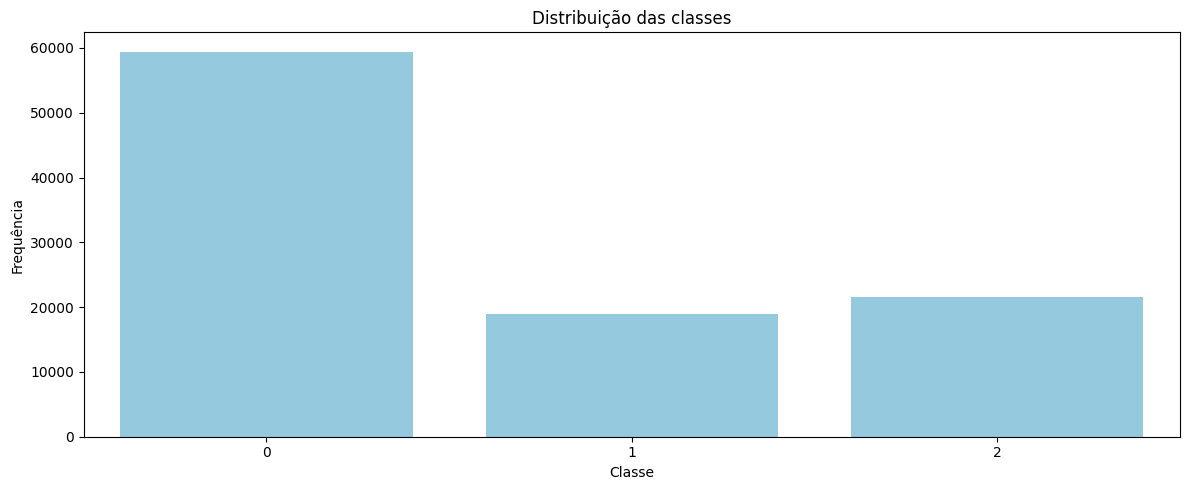

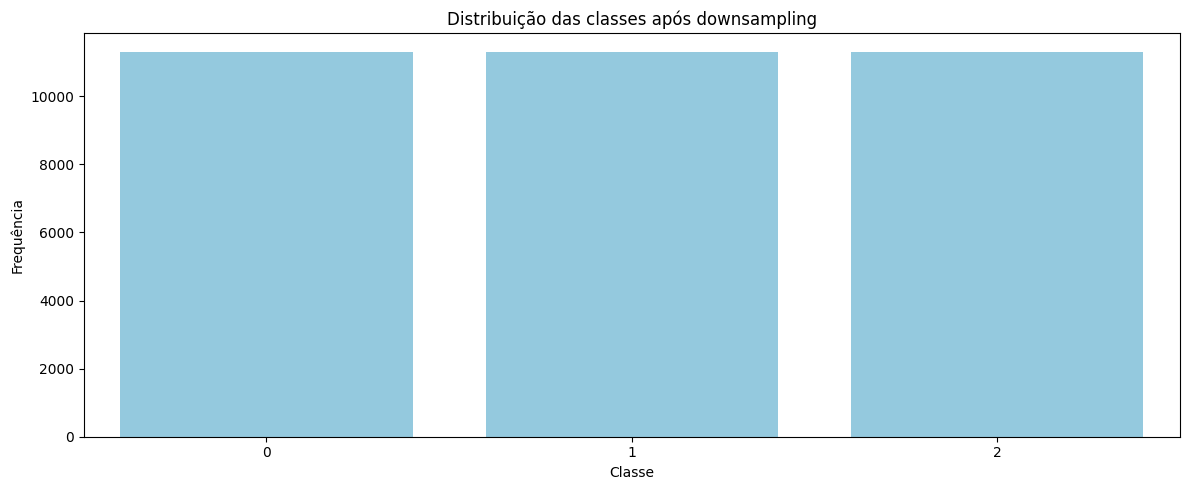

In [18]:
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='class', color='skyblue')
plt.title(f'Distribuição das classes')
plt.xlabel('Classe')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()
print()

plt.figure(figsize=(12, 5))
sns.countplot(data=balanced_train_df, x='class', color='skyblue')
plt.title(f'Distribuição das classes após downsampling')
plt.xlabel('Classe')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()
print()

In [19]:
# Treinamento das arquiteturas propostas com auxílio da regra de pirâmide de acordo com (método 2)

architectures_results_method2 = []

for i, (layers, solver, activation, iterations, n_times) in enumerate(architectures, start=1):
    print(f'\n Treinando Arquitetura {i}/10')
    res = train_model(X_train_balanced, X_test_std_df, y_train_balanced, y_test,
                      layers, solver, activation, iterations, n_times)
    architectures_results_method2.append(res)

medias_architectures_results_method2 = []
desvios_architectures_results_method2 = []

for result in architectures_results_method2:
    result = np.array(result)
    medias_architectures_results_method2.append(np.mean(result, axis=0).tolist())
    desvios_architectures_results_method2.append(np.std(result, axis=0).tolist())

# Construção da Tabela usando Prettytable
table = PrettyTable()
table.title= 'Treinamento de arquiteturas com método da pirâmide | Downsampling'
table.field_names = ['Arquitetura', 'Acurácia','Precisão','Revocação','F1-Score']

# Adicionando os campos da tabela
for i in range(len(arbitrary_architectures)):
    table.add_row([f'{i+1}',
                   f'{medias_architectures_results_method2[i][0]:.4f} ± {desvios_architectures_results_method2[i][0]:.4f}',
                   f'{medias_architectures_results_method2[i][1]:.4f} ± {desvios_architectures_results_method2[i][1]:.4f}',
                   f'{medias_architectures_results_method2[i][2]:.4f} ± {desvios_architectures_results_method2[i][2]:.4f}',
                   f'{medias_architectures_results_method2[i][3]:.4f} ± {desvios_architectures_results_method2[i][3]:.4f}'
                   ])
print(table)


 Treinando Arquitetura 1/10
Arquitetura com solver = adam,  activation = relu camadas ocultas=(10, 3)  Taxa de aprendizado=0.001 e n° de iterações=200 por 10
Execução 1/10
Execução 2/10
Execução 3/10
Execução 4/10
Execução 5/10
Execução 6/10
Execução 7/10
Execução 8/10
Execução 9/10
Execução 10/10

 Treinando Arquitetura 2/10
Arquitetura com solver = sgd,  activation = tanh camadas ocultas=(3, 10)  Taxa de aprendizado=0.001 e n° de iterações=200 por 10
Execução 1/10
Execução 2/10
Execução 3/10
Execução 4/10
Execução 5/10
Execução 6/10
Execução 7/10
Execução 8/10
Execução 9/10
Execução 10/10

 Treinando Arquitetura 3/10
Arquitetura com solver = adam,  activation = relu camadas ocultas=(5, 8)  Taxa de aprendizado=0.001 e n° de iterações=200 por 10
Execução 1/10
Execução 2/10
Execução 3/10
Execução 4/10
Execução 5/10
Execução 6/10
Execução 7/10
Execução 8/10
Execução 9/10
Execução 10/10

 Treinando Arquitetura 4/10
Arquitetura com solver = sgd,  activation = tanh camadas ocultas=(8, 5)  

In [20]:
# Treinamento das arquiteturas propostas com auxílio da regra de pirâmide de acordo com (método 2)

arbitrary_results_architectures_results_method2 = []

for i, (layers, solver, activation, iterations, n_times) in enumerate(arbitrary_architectures, start=1):
    print(f'\n Treinando Arquitetura {i}/5')
    res = train_model(X_train_balanced, X_test_std_df, y_train_balanced, y_test,
                      layers, solver, activation, iterations, n_times)
    arbitrary_results_architectures_results_method2.append(res)

medias_arbitrary_results_architectures_results_method2 = []
desvios_arbitrary_results_architectures_results_method2 = []

for result in arbitrary_results_architectures_results_method2:
    result = np.array(result)
    medias_arbitrary_results_architectures_results_method2 .append(np.mean(result, axis=0).tolist())
    desvios_arbitrary_results_architectures_results_method2.append(np.std(result, axis=0).tolist())

# Construção da Tabela usando Prettytablez
table = PrettyTable()
table.title= 'Treinamento de arquiteturas com método da pirâmide | Downsampling'
table.field_names = ['Arquitetura', 'Acurácia','Precisão','Revocação','F1-Score']

# Adicionando os campos da tabela
for i in range(len(arbitrary_architectures)):
    table.add_row([f'{i+1}',
                   f'{medias_arbitrary_results_architectures_results_method2[i][0]:.4f} ± {desvios_arbitrary_results_architectures_results_method2[i][0]:.4f}',
                   f'{medias_arbitrary_results_architectures_results_method2[i][1]:.4f} ± {desvios_arbitrary_results_architectures_results_method2[i][1]:.4f}',
                   f'{medias_arbitrary_results_architectures_results_method2[i][2]:.4f} ± {desvios_arbitrary_results_architectures_results_method2[i][2]:.4f}',
                   f'{medias_arbitrary_results_architectures_results_method2[i][3]:.4f} ± {desvios_arbitrary_results_architectures_results_method2[i][3]:.4f}'
                   ])
print(table)


 Treinando Arquitetura 1/5
Arquitetura com solver = adam,  activation = relu camadas ocultas=(32, 64)  Taxa de aprendizado=0.001 e n° de iterações=200 por 10
Execução 1/10
Execução 2/10
Execução 3/10
Execução 4/10
Execução 5/10
Execução 6/10
Execução 7/10
Execução 8/10
Execução 9/10
Execução 10/10

 Treinando Arquitetura 2/5
Arquitetura com solver = adam,  activation = logistic camadas ocultas=(48, 64)  Taxa de aprendizado=0.001 e n° de iterações=200 por 10
Execução 1/10
Execução 2/10
Execução 3/10
Execução 4/10
Execução 5/10
Execução 6/10
Execução 7/10
Execução 8/10
Execução 9/10
Execução 10/10

 Treinando Arquitetura 3/5
Arquitetura com solver = adam,  activation = tanh camadas ocultas=(12, 12)  Taxa de aprendizado=0.001 e n° de iterações=200 por 10
Execução 1/10
Execução 2/10
Execução 3/10
Execução 4/10
Execução 5/10
Execução 6/10
Execução 7/10
Execução 8/10
Execução 9/10
Execução 10/10

 Treinando Arquitetura 4/5
Arquitetura com solver = adam,  activation = relu camadas ocultas=(3

### **Obtendo a melhor arquitetura utilizando o método 2**

In [21]:
# Agrupa todas as arquiteturas 
all_architectures = architectures + arbitrary_architectures

# Agrupa toda a lista de médias 
all_means = medias_architectures_results_method2 + medias_arbitrary_results_architectures_results_method2

# Extrai apenas a média de f1-scores
f1_scores = [m[3] for m in all_means]

top1_idx = int(np.argmax(f1_scores))
top1_method2_f1 = f1_scores[top1_idx]
top1_method2_params = all_architectures[top1_idx]

**Análise de métricas**

Diante da análise dos valores de F1-Score de ambas as abordagens para o mesmo conjunto de testes, nota-se proximidade entre os valores. Tal proximidade se deu para uma única execução de um único modelo para cada abordagem, sendo possível que outras execuções favoreçam uma abordagem em dentrimento da outra.

Nesse cenário, a segunda abordagem mostra-se viável, dado que permite a obtenção de um métrica próxima à primeira, com uma quantidade de dados muito menor.

**Grid Search**

In [22]:
# Função que realiza o grid
def grid_search(mlp, parameters, scorers, X, y):
    search = GridSearchCV(mlp, parameters, scoring=scorers, n_jobs=-1, verbose=2, refit='f1-score')
    search.fit(X,y)
    return search.cv_results_, search.best_params_, search.best_score_, search.best_estimator_

# Parâmetros do Grid Search
parameters = {
    'solver': ['adam', 'sgd'], # Solver
    'batch_size': [100, 200], # Tamanho de lote
    'learning_rate_init': [0.0001, 0.001, 0.01], # Taxa de aprendizado
    'n_iter_no_change': [10, 20], # Paciência
    'max_iter': [100, 200] # Número de épocas
}

# Métricas utilizadas 
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'f1-score': make_scorer(f1_score, average='weighted'),
    'revocação': make_scorer( recall_score, average='weighted'),
    'precisão':make_scorer(precision_score, average='weighted')
}

### **Matriz de Confusão das 2 melhores arquiteturas utilizando o melhores hiperparâmetros encontrados para a mesmas**


Executando Grid Search para arquitetura: (32, 64), adam, relu
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Melhores parâmetros: {'batch_size': 100, 'learning_rate_init': 0.01, 'max_iter': 100, 'n_iter_no_change': 20, 'solver': 'sgd'}
Acurácia: 0.9711, F1-Score: 0.9709


C:\Users\adraf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


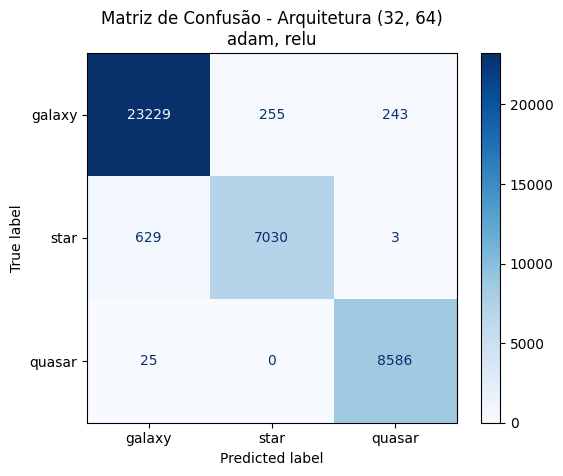

In [23]:
# Parâmetros da arquitetura top 1 do método 1
layers, solver, activation, _ , _ = top1_method1_params

# Declarando o modelo que vai ser utilizado dentro do grid
model = MLPClassifier(hidden_layer_sizes=layers,
                      solver=solver,
                      activation=activation,
                      alpha=0.001,
                      learning_rate_init=0.001,
                      n_iter_no_change=10,
                      max_iter=200,
                      random_state=42,
                      early_stopping=True
                      )

print(f"\nExecutando Grid Search para arquitetura: {layers}, {solver}, {activation}")

_ , best_paremeters, _ , best_estimator = grid_search(model, parameters, scorers, X_train_std, y_train)

# Treina modelo final com melhores parâmetros
best_model_1 = best_estimator
best_model_1.fit(X_train_std, y_train)
y_pred = best_model_1.predict(X_test_std_df)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"\nMelhores parâmetros: {best_paremeters}")
print(f"Acurácia: {acc:.4f}, F1-Score: {f1:.4f}")

# Plota matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_label_map)
disp.plot(cmap='Blues')
plt.title(f"Matriz de Confusão - Arquitetura {layers}\n{solver}, {activation}")
plt.show()


Executando Grid Search para arquitetura: (36, 24), adam, relu
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Melhores parâmetros: {'batch_size': 100, 'learning_rate_init': 0.001, 'max_iter': 200, 'n_iter_no_change': 20, 'solver': 'adam'}
Acurácia: 0.9690, F1-Score: 0.9690


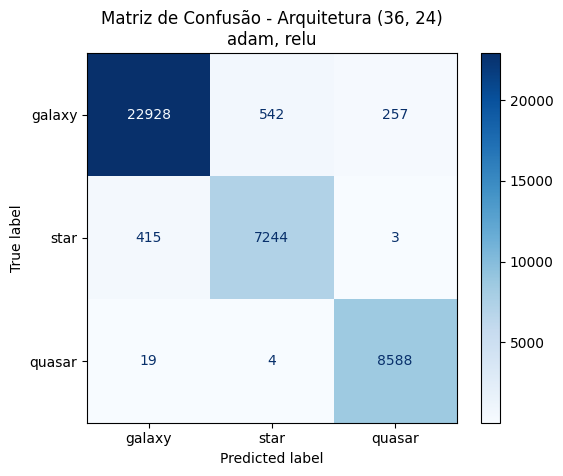

In [24]:
# Parâmetros da arquitetura top 1 do método 1
layers, solver, activation, _ , _ = top1_method2_params

# Declarando o modelo que vai ser utilizado dentro do grid
model = MLPClassifier(hidden_layer_sizes=layers,
                      solver=solver,
                      activation=activation,
                      alpha=0.001,
                      learning_rate_init=0.001,
                      n_iter_no_change=10,
                      max_iter=200,
                      random_state=42,
                      early_stopping=True
                      )

print(f"\nExecutando Grid Search para arquitetura: {layers}, {solver}, {activation}")

_ , best_paremeters, _ , best_estimator = grid_search(model, parameters, scorers, X_train_balanced, y_train_balanced)

# Treina modelo final com melhores parâmetros
best_model_2 = best_estimator
best_model_2.fit(X_train_balanced, y_train_balanced)
y_pred = best_model_2.predict(X_test_std_df)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"\nMelhores parâmetros: {best_paremeters}")
print(f"Acurácia: {acc:.4f}, F1-Score: {f1:.4f}")

# Plota matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_label_map)
disp.plot(cmap='Blues')
plt.title(f"Matriz de Confusão - Arquitetura {layers}\n{solver}, {activation}")
plt.show()

### **Como o melhor modelo se comporta sem o 'weighted'?** ###

C:\Users\ritab\PycharmProjects\rna\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(



Melhores parâmetros: {'batch_size': 200}
Acurácia: 0.9692, F1-Score: 0.9646


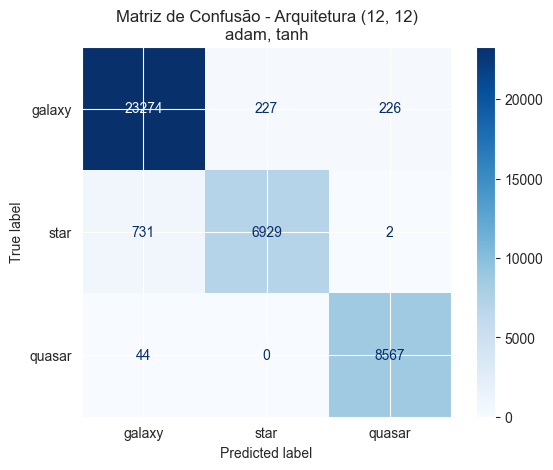

In [ ]:
# # Treinando o melhor modelo mais uma vez.
# best_model_1.fit(X_train_std, y_train)
# y_pred = best_model_1.predict(X_test_std_df)
# acc = accuracy_score(y_test, y_pred)
# 
# # Retirando o weighted e colocando macro
# f1 = f1_score(y_test, y_pred, average='macro')
# print(f"\nMelhores parâmetros: {best_paremeters}")
# print(f"Acurácia: {acc:.4f}, F1-Score: {f1:.4f}")
# 
# # Plota matriz de confusão
# cm = confusion_matrix(y_test, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_label_map)
# disp.plot(cmap='Blues')
# plt.title(f"Matriz de Confusão - Arquitetura {layers}\n{solver}, {activation}")
# plt.show()

**Modelo final** (Será feito o salvamento do modelo final, após o treinamento das células anteriores, 